In [1]:
!pip install https://github.com/stefanloock/pyshearlab/archive/master.zip

     | 99.8 kB 498.9 kB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyshearlab: filename=pyshearlab-0.0.1-py3-none-any.whl size=36593 sha256=507d988c3e672bb7af1611c497687dd7bab46cdcd55602134732053ffb1fc8e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xkvelnao/wheels/ce/15/63/5986e906af5b4f646f016792f1f40af639710d02869648624f
Successfully built pyshearlab


In [2]:
!pip install fingerprint_enhancer

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.13-py3-none-any.whl size=8907 sha256=55c33b2ca67556286b1195b171c57f359bee1da52c59b1a6961b0efb20968dfe
  Stored in directory: /root/.cache/pip/wheels/91/ae/50/978165dd230375061475f4594febfe8a42869c4cc5374f9740
Successfully built fingerprint_enhancer


In [3]:
!pip install kymatio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.8 MB/s eta 0:00:00


In [4]:
!pip install torchsummary

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
from scipy import io as sio
# import pyshearlab
import imageio
import fingerprint_enhancer								# Load the library
import cv2
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from sklearn import metrics as sklearn_metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import sys
from tqdm import tqdm
from tensorflow.keras import layers, models , optimizers , losses ,activations , callbacks, metrics
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import vgg16

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the Scattering Transform
from kymatio.torch import Scattering2D

In [9]:
import os
import random
import numpy as np
import cv2
import fingerprint_enhancer  # Make sure this library is imported

class FingerprintTripletGenerator:
    def __init__(self, datasetPath):
        self.personDict = self.generate_person_dictionary(datasetPath)

    def generate_person_dictionary(self, datasetPath):
        personDict = {}
        for filename in os.listdir(datasetPath):
            person_name, image_number = filename.split('_')
            if person_name not in personDict:
                personDict[person_name] = []
            personDict[person_name].append(filename)
        return personDict

    def preprocess_image(self, img_path):
        img = cv2.imread(img_path, 0)
        out = fingerprint_enhancer.enhance_Fingerprint(img)
        return out

    def get_next_element_for_person(self, person_name):
        anchorPhoto = random.choice(self.personDict[person_name])

        # Make sure the anchor image is not selected as positive
        positivePhoto = random.choice(self.personDict[person_name])
        while positivePhoto == anchorPhoto:
            positivePhoto = random.choice(self.personDict[person_name])

        # Select a different person for the negative sample
        negativePerson = random.choice(list(self.personDict.keys()))
        while negativePerson == person_name:
            negativePerson = random.choice(list(self.personDict.keys()))

        # Select a random image from the negative person
        negativePhoto = random.choice(self.personDict[negativePerson])

        # Preprocess images
        anchor_img = self.preprocess_image(os.path.join(datasetPath, anchorPhoto))
        positive_img = self.preprocess_image(os.path.join(datasetPath, positivePhoto))
        negative_img = self.preprocess_image(os.path.join(datasetPath, negativePhoto))

        return anchor_img, positive_img, negative_img

# Example usage
datasetPath = "/content/drive/MyDrive/Scanner"
fingerprint_generator = FingerprintTripletGenerator(datasetPath)

In [ ]:
#Choose a specific number of keys to use for training data
num_keys_for_training = 200  # You can set this to your desired number
training_data = []

selected_keys = random.sample(list(fingerprint_generator.personDict.keys()), num_keys_for_training)
# print(selected_keys)
anchor_images = []
positive_images = []
negative_images = []
for person in selected_keys:
    anchor_img, positive_img, negative_img = fingerprint_generator.get_next_element_for_person(person)
    # Assuming shearlet_transform is a function you have defined for your preprocessing
    pad_width = 30
    anchor_img = np.pad(anchor_img, (pad_width, pad_width), mode='constant', constant_values=0)
    positive_img = np.pad(positive_img, (pad_width, pad_width), mode='constant', constant_values=0)
    negative_img = np.pad(negative_img, (pad_width, pad_width), mode='constant', constant_values=0)
    anchor_images.append(np.array(Image.fromarray(anchor_img).resize((320,320))))
    positive_images.append(np.array(Image.fromarray(positive_img).resize((320,320))))
    negative_images.append(np.array(Image.fromarray(negative_img).resize((320,320))))
    # training_data.append([shearlet_transform(anchor_img), shearlet_transform(positive_img), shearlet_transform(negative_img)])

In [ ]:
save_path = '/content/drive/MyDrive/training_data.npz'
np.savez(save_path, anchor=anchor_images, positive=positive_images, negative=negative_images)

In [10]:
save_path = '/content/drive/MyDrive/training_data.npz'
loaded_data = np.load(save_path)
loaded_anchor_images = loaded_data['anchor']
loaded_positive_images = loaded_data['positive']
loaded_negative_images = loaded_data['negative']

In [11]:
loaded_anchor_images.shape

(200, 320, 320)

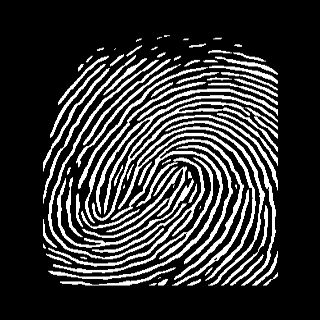

In [12]:
cv2_imshow(np.array(loaded_anchor_images[0]))

In [13]:
loaded_anchor_images = np.resize(loaded_anchor_images,(200,1,320,320))
loaded_positive_images = np.resize(loaded_positive_images,(200,1,320,320))
loaded_negative_images = np.resize(loaded_negative_images,(200,1,320,320))

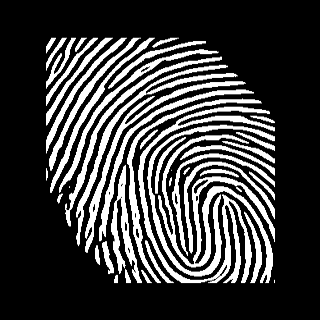

In [14]:
cv2_imshow(np.array(loaded_anchor_images[7].reshape(320,320)))

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split

class TripletDataset(Dataset):
    def __init__(self, anchor_images, positive_images, negative_images,shape = (320,320), transform=None):
        self.anchor_images = anchor_images
        self.positive_images = positive_images
        self.negative_images = negative_images
        self.transform = transform

    def __len__(self):
        return len(self.anchor_images)

    def __getitem__(self, idx):
        anchor = self.anchor_images[idx]
        positive = self.positive_images[idx]
        negative = self.negative_images[idx]

        # Apply transformations if provided
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# Assuming loaded_anchor_images, loaded_positive_images, loaded_negative_images are lists of image data
# Make sure each list has the same length

# # Create a TripletDataset
# transform = transforms.Compose([transforms.ToTensor()])  # Add your custom transformations
# triplet_dataset = TripletDataset(loaded_anchor_images, loaded_positive_images, loaded_negative_images, transform)

In [17]:
scattering = Scattering2D(J = 4,L = 6,max_order = 1,shape=(320, 320))
anchor_scattering_J4_L6 = scattering(torch.from_numpy(loaded_anchor_images/255.0).float())
positive_scattering_J4_L6 = scattering(torch.from_numpy(loaded_positive_images/255.0).float())
negative_scattering_J4_L6 = scattering(torch.from_numpy(loaded_negative_images/255.0).float())

In [23]:
shape = anchor_scattering_J4_L6.shape
anchor_scattering_J4_L6 = np.reshape(anchor_scattering_J4_L6,(shape[0],shape[1]*shape[2],shape[3],shape[4]))
positive_scattering_J4_L6 = np.reshape(positive_scattering_J4_L6,(shape[0],shape[1]*shape[2],shape[3],shape[4]))
negative_scattering_J4_L6 = np.reshape(negative_scattering_J4_L6,(shape[0],shape[1]*shape[2],shape[3],shape[4]))

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(24)
        self.conv1 = nn.Conv2d(24, 32, kernel_size=3, stride=1)# 18,18
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)# 16,16
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)# 8,8
        self.bn4 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)# 6,6
        self.bn5 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1)# 4,4
        self.bn6 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # self.fc2 = nn.Linear(1024, 512)

    def forward(self, x):
        x = F.relu(self.bn2(self.conv1(self.bn1(x))))
        x = F.relu(self.bn3(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv3(self.bn4(x))))
        x = F.relu(self.bn6(self.conv4(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        return x

class TripletNet(nn.Module):
    def __init__(self, embedding_model):
        super(TripletNet, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, anchor, positive, negative):
        output_anchor = self.embedding_model(anchor)
        output_positive = self.embedding_model(positive)
        output_negative = self.embedding_model(negative)
        return output_anchor, output_positive, output_negative

# Example usage:
imsize = 20
embedding_model = EmbeddingModel()
triplet_net = TripletNet(embedding_model)
optimizer = optim.Adam(triplet_net.parameters(), lr=0.001)

In [43]:
from torchsummary import summary

# Assuming your device is 'cuda' if available, else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
triplet_net.to(device)
imsize = 20
# Print the summary
result = summary(triplet_net, [(24, imsize, imsize), (24, imsize, imsize), (24, imsize, imsize)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 24, 20, 20]              48
            Conv2d-2           [-1, 32, 18, 18]           6,944
       BatchNorm2d-3           [-1, 32, 18, 18]              64
            Conv2d-4           [-1, 32, 16, 16]           9,248
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
       BatchNorm2d-7             [-1, 32, 8, 8]              64
            Conv2d-8             [-1, 64, 6, 6]          18,496
       BatchNorm2d-9             [-1, 64, 6, 6]             128
           Conv2d-10             [-1, 64, 4, 4]          36,928
      BatchNorm2d-11             [-1, 64, 4, 4]             128
           Linear-12                  [-1, 512]         524,800
   EmbeddingModel-13                  [-1, 512]               0
      BatchNorm2d-14           [-1, 24,

In [44]:
transform = transforms.Compose([transforms.ToTensor()])  # Add your custom transformations
triplet_dataset = TripletDataset(anchor_scattering_J4_L6[:,1:,:,:], positive_scattering_J4_L6[:,1:,:,:], negative_scattering_J4_L6[:,1:,:,:], transform)
train_size = int(0.7 * 200)
val_size = int(0.15 * 200)
test_size = len(triplet_dataset) - train_size - val_size

# Use random_split to split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(triplet_dataset, [train_size, val_size, test_size])

# Define data loaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# Now you can use this dataloader in your training loop

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a function to calculate accuracy
def calculate_accuracy(output_anchor, output_positive, output_negative):
    pos_dist = (output_anchor - output_positive).pow(2).sum(1)
    neg_dist = (output_anchor - output_negative).pow(2).sum(1)

    # If positive distance is smaller than negative distance, it's a correct match
    correct_matches = (pos_dist < neg_dist).float().sum()

    # Calculate accuracy as the ratio of correct matches to the total number of samples
    accuracy = correct_matches / len(output_anchor)

    return accuracy.item()

num_epochs = 20
train_accuracies = []
val_accuracies = []
train_losses = []
triplet_net.train()

# Assuming you have train_dataloader and val_dataloader for training and validation
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0

    # Training phase
    triplet_net.train()
    for batch in train_dataloader:
        anchor, positive, negative = batch
        optimizer.zero_grad()
        output_anchor, output_positive, output_negative = triplet_net(anchor, positive, negative)

        # Assuming you have a triplet loss implementation
        margin = 1.0
        triplet_margin_loss = nn.TripletMarginLoss(margin=margin)

        # Calculate the loss
        loss = triplet_margin_loss(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        accuracy = calculate_accuracy(output_anchor, output_positive, output_negative)
        total_accuracy += accuracy
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    average_accuracy = total_accuracy / len(train_dataloader)
    train_accuracies.append(average_accuracy)
    train_losses.append(average_loss)

    # Validation phase
    triplet_net.eval()
    total_val_accuracy = 0.0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_anchor, val_positive, val_negative = val_batch
            val_output_anchor, val_output_positive, val_output_negative = triplet_net(val_anchor, val_positive, val_negative)

            # Calculate validation accuracy
            val_accuracy = calculate_accuracy(val_output_anchor, val_output_positive, val_output_negative)
            total_val_accuracy += val_accuracy

    average_val_accuracy = total_val_accuracy / len(val_dataloader)
    val_accuracies.append(average_val_accuracy)


    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {average_accuracy}, Val Accuracy: {average_val_accuracy}')


Epoch 1/20, Loss: 0.4083905087576972, Accuracy: 0.8402777777777778, Val Accuracy: 0.8958333283662796
Epoch 2/20, Loss: 0.30956101086404586, Accuracy: 0.8958333333333334, Val Accuracy: 0.90625
Epoch 3/20, Loss: 0.24617703755696616, Accuracy: 0.9236111111111112, Val Accuracy: 0.8020833283662796
Epoch 4/20, Loss: 0.3503368530008528, Accuracy: 0.8819444444444444, Val Accuracy: 0.8645833283662796
Epoch 5/20, Loss: 0.2538481288486057, Accuracy: 0.9444444444444444, Val Accuracy: 0.96875
Epoch 6/20, Loss: 0.1586158126592636, Accuracy: 0.9652777777777778, Val Accuracy: 0.8958333283662796
Epoch 7/20, Loss: 0.2582365903589461, Accuracy: 0.9305555555555556, Val Accuracy: 0.8854166716337204
Epoch 8/20, Loss: 0.19586346877945793, Accuracy: 0.9375, Val Accuracy: 0.9583333283662796
Epoch 9/20, Loss: 0.05309063196182251, Accuracy: 0.9930555555555556, Val Accuracy: 0.9270833283662796
Epoch 10/20, Loss: 0.12375852796766493, Accuracy: 0.9513888888888888, Val Accuracy: 0.8854166716337204
Epoch 11/20, Loss:

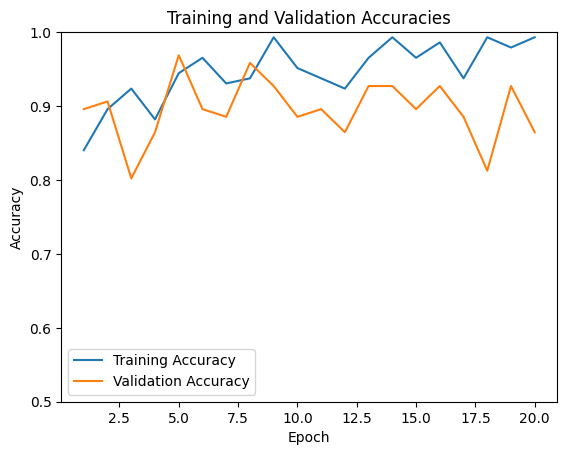

In [46]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

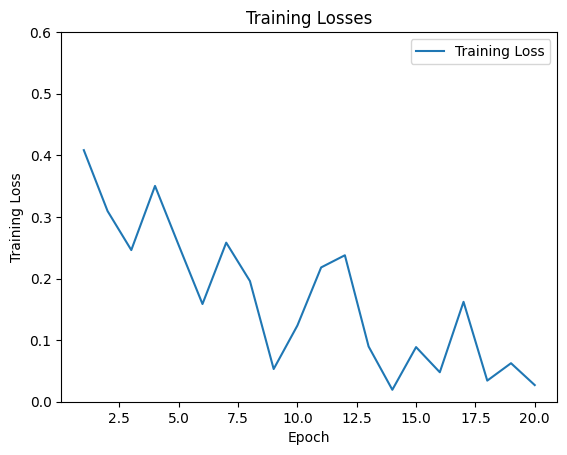

In [49]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Losses')
plt.ylim(0,0.6)
plt.legend()
plt.show()

In [50]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a test_dataloader for testing
# Modify this based on your actual dataset and model

# Set the model to evaluation mode
triplet_net.eval()

# Lists to store anchor, positive, and negative distances
all_positive_distances = []
all_negative_distances = []
predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for test_batch in test_dataloader:
        test_anchor, test_positive, test_negative = test_batch

        # Get embeddings from the model
        anchor_embedding = embedding_model(test_anchor)
        positive_embedding = embedding_model(test_positive)
        negative_embedding = embedding_model(test_negative)

        # Calculate distances
        positive_distance = torch.sum((anchor_embedding - positive_embedding).pow(2), dim=1)
        negative_distance = torch.sum((anchor_embedding - negative_embedding).pow(2), dim=1)

        # Append distances to the lists
        predictions.append((positive_distance < negative_distance))
        all_positive_distances.extend(positive_distance.cpu().numpy())
        all_negative_distances.extend(negative_distance.cpu().numpy())

# Convert lists to PyTorch tensors
all_positive_distances = torch.tensor(all_positive_distances)
all_negative_distances = torch.tensor(all_negative_distances)

# Calculate accuracy based on distances
# print(all_positive_distances)
# print(all_negative_distances)
correct_matches = (all_positive_distances < all_negative_distances).sum().item()
total_samples = len(all_positive_distances)
accuracy = correct_matches / total_samples

print(f'Test Accuracy: {accuracy :.5f}%')

Test Accuracy: 0.90000%


In [51]:
# cv2_imshow(np.array(loaded_anchor_images[0]).reshape(320,320))
# cv2_imshow(np.array(loaded_positive_images[0].reshape(320,320)))
# cv2_imshow(np.array(loaded_negative_images[0].reshape(320,320)))
# anchor_embedding = embedding_model(anchor_scattering[:,1:,:,:])
# positive_embedding = embedding_model(positive_scattering[:,1:,:,:])
# negative_embedding = embedding_model(negative_scattering[:,1:,:,:])
# positive_distance = torch.sum((anchor_embedding - positive_embedding).pow(2), dim=1)
# negative_distance = torch.sum((anchor_embedding - negative_embedding).pow(2), dim=1)

In [52]:
print(positive_distance[0])
print(negative_distance[0])

tensor(61.1050)
tensor(970.6813)


In [54]:
img2 = np.array(loaded_anchor_images[0].reshape(320,320))
img1 = np.array(loaded_positive_images[0].reshape(320,320))
img3 = np.array(loaded_negative_images[0].reshape(320,320))
stacked_img = np.hstack((img1, img2, img3))

# # Display the stacked image
# plt.imshow(stacked_img)
# plt.axis('off')
# plt.show()
# print(positive_distance[0])
# print(negative_distance[0])

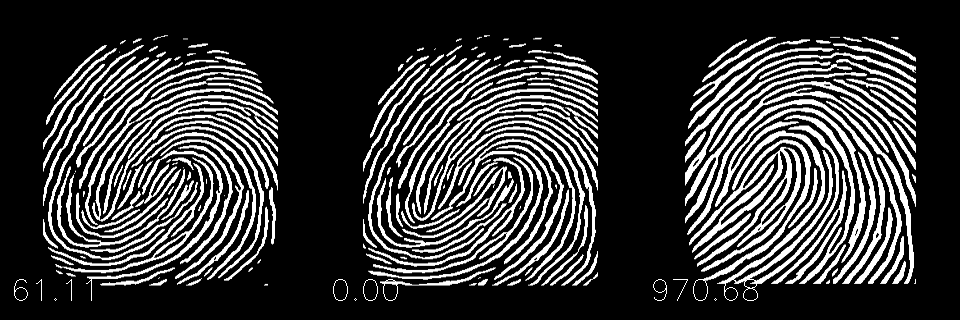

In [55]:
import cv2

# Ensure all images have the same height
height = min(img1.shape[0], img2.shape[0], img3.shape[0])

# Resize images to have the same height
img1 = cv2.resize(img1, (int(img1.shape[1] * height / img1.shape[0]), height))
img2 = cv2.resize(img2, (int(img2.shape[1] * height / img2.shape[0]), height))
img3 = cv2.resize(img3, (int(img3.shape[1] * height / img3.shape[0]), height))

# Stack images horizontally
stacked_img = np.hstack((img1, img2, img3))

# Add labels to the stacked image
label1 = f'{positive_distance[0]:.2f}'
label2 = f'0.00'  # Assuming anchor distance is always 0
label3 = f'{negative_distance[0]:.2f}'

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 1
font_color = (255, 255, 255)  # White color

cv2.putText(stacked_img, label1, (10, height - 20), font, font_scale, font_color, font_thickness)
cv2.putText(stacked_img, label2, (img1.shape[1] + 10, height - 20), font, font_scale, font_color, font_thickness)
cv2.putText(stacked_img, label3, (img1.shape[1] + img2.shape[1] + 10, height - 20), font, font_scale, font_color, font_thickness)

# Display the stacked and labeled image
cv2_imshow(stacked_img)

# CNN TRIPLET SIAMESE NETWORK

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K

def create_cnn_block(input_shape):
    # Define a basic CNN block
    input_layer = Input(shape=input_shape)# 320,320
    x = Conv2D(32, (5, 5), activation='relu')(input_layer)# 316,316
    x = MaxPooling2D((2, 2))(x)# 158,158
    x = Conv2D(64, (3, 3), activation='relu')(x) # 156,156
    x = MaxPooling2D((2, 2))(x)# 78,78
    x = Conv2D(64, (3, 3), activation='relu')(x)# 76,76
    x = MaxPooling2D((2, 2))(x)# 38,38
    x = Conv2D(128, (3, 3), activation='relu')(x)# 36,36
    x = MaxPooling2D((2, 2))(x)# 18,18
    x = Conv2D(128, (3, 3), activation='relu')(x)# 16,16
    x = MaxPooling2D((2, 2))(x)# 8,8,128

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_layer, x)

def triplet_siamese_model(input_shape):
    # Create the anchor, positive, and negative inputs
    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Shared CNN block
    cnn_block = create_cnn_block(input_shape)

    # Process each input image through the shared CNN
    anchor_embedding = cnn_block(anchor_input)
    positive_embedding = cnn_block(positive_input)
    negative_embedding = cnn_block(negative_input)


    # Merge the anchor, positive, and negative embeddings
    merged_output = Lambda(lambda x: K.concatenate(x, axis=1))([anchor_embedding, positive_embedding, negative_embedding])

    # Create the triplet Siamese model
    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
    margin = 1.0
    triplet_margin_loss = nn.TripletMarginLoss(margin=margin)
    model.compile(loss=triplet_margin_loss, optimizer='adam')

    return model

# Specify the input shape
input_shape = (320, 320, 3)

# Create the triplet Siamese model
model = triplet_siamese_model(input_shape)

# Display the model summary
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 320, 320, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 320, 320, 3)]        0         []                            
 )                                                                                                
                                                                                           